# BattleZone (Atari) con DQN + PER

Este notebook entrena un agente DQN con Prioritized Experience Replay (PER) en `ALE/BattleZone-v5`.
BattleZone es un juego de tanques en primera persona con perspectiva 3D, 18 acciones posibles y recompensas dispersas por destruccion de vehiculos enemigos.
Incluye preprocesamiento Atari, checkpoints para reanudar entrenamiento, logging con TensorBoard, evaluacion formal vs baseline aleatorio, graficas y video final.

## Setup Colab
Ejecuta las siguientes celdas en orden. El setup instala dependencias, valida versiones, confirma GPU y realiza un smoke test del entorno.

In [1]:
# Setup optimizado para Colab con GPU
import os
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # Mejor debugging CUDA

# Desinstalar TensorFlow para evitar conflictos
!pip uninstall -y tensorflow tensorflow-gpu -q 2>/dev/null || true

# Instalar dependencias core
!pip -q install gymnasium[atari,accept-rom-license] ale-py autorom torch tensorboard

# Descargar ROMs
!AutoROM --accept-license -q

import gc
import json
import time
import subprocess
import sys
import platform
import numpy as np
import torch
import gymnasium as gym
import ale_py

# Forzar limpieza de memoria GPU
torch.cuda.empty_cache()
gc.collect()

ROOT_DIR = "/content" if os.path.exists("/content") else os.getcwd()
ART_ROOT = os.path.join(ROOT_DIR, "artifacts", "battlezone")
CKPT_DIR = os.path.join(ART_ROOT, "checkpoints")
FINAL_DIR = os.path.join(ART_ROOT, "final_model")
LOG_DIR = os.path.join(ART_ROOT, "logs")
VIDEO_DIR = os.path.join(ART_ROOT, "videos")
CONFIG_PATH = os.path.join(ART_ROOT, "config.json")
for d in [CKPT_DIR, FINAL_DIR, LOG_DIR, VIDEO_DIR]:
    os.makedirs(d, exist_ok=True)

SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("="*80)
print("SETUP FINALIZADO")
print("="*80)
print("Dispositivo:", DEVICE)
print("Python:", sys.version.replace("\n", " "))
print("Platform:", platform.platform())
print("Torch:", torch.__version__)
print("Gymnasium:", gym.__version__)
print("ale_py:", ale_py.__version__)
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("\nnvidia-smi:")
    try:
        print(subprocess.check_output(["nvidia-smi"]).decode())
    except Exception as e:
        print("nvidia-smi no disponible:", e)
else:
    print("GPU: No disponible")
print("="*80)

Usage: AutoROM [OPTIONS]
Try 'AutoROM --help' for help.

Error: No such option: -q
SETUP FINALIZADO
Dispositivo: cuda
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Torch: 2.9.0+cu128
Gymnasium: 1.2.3
ale_py: 0.11.2
CUDA disponible: True
GPU: NVIDIA A100-SXM4-80GB

nvidia-smi:
Mon Feb 16 21:09:22 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+===========

In [2]:
# Smoke test: crear entorno, reset y step + GPU warmup
print("Iniciando smoke test...")
try:
    test_env = gym.make("ALE/BattleZone-v5", frameskip=1, repeat_action_probability=0.0)
    obs, info = test_env.reset(seed=SEED)
    action = test_env.action_space.sample()
    next_obs, reward, terminated, truncated, info = test_env.step(action)
    print("\u2713 Smoke test OK")
    print("  obs.shape:", obs.shape, "| n_actions:", test_env.action_space.n)
    test_env.close()

    # GPU warmup: torch tensor en CUDA
    print("  GPU warmup...", end=" ")
    warmup = torch.randn(1, 4, 84, 84, device=DEVICE)
    _ = warmup * 2
    torch.cuda.synchronize() if DEVICE == "cuda" else None
    print("\u2713")

except Exception as e:
    raise RuntimeError(
        "Smoke test failed. Revisa instalaciones, ROMs, GPU y el runtime."
    ) from e

print("Todo listo para entrenar.\n")

Iniciando smoke test...
✓ Smoke test OK
  obs.shape: (210, 160, 3) | n_actions: 18
  GPU warmup... ✓
Todo listo para entrenar.



In [3]:
# Monitoreo de RAM disponible
import psutil
ram = psutil.virtual_memory()
print("="*80)
print("MEMORIA DEL SISTEMA")
print("="*80)
print(f"RAM total: {ram.total / (1024**3):.1f} GB")
print(f"RAM disponible: {ram.available / (1024**3):.1f} GB")
print(f"RAM usada: {ram.percent:.1f}%")
if ram.available / (1024**3) < 10:
    print("\n\u26a0\ufe0f  ADVERTENCIA: Menos de 10GB disponibles. Considera:")
    print("   - Reiniciar runtime")
    print("   - Reducir buffer_size a 50_000")
print("="*80 + "\n")

MEMORIA DEL SISTEMA
RAM total: 167.1 GB
RAM disponible: 164.2 GB
RAM usada: 1.7%



## Entorno, wrappers y PER
Se definen wrappers consistentes para entrenamiento y evaluacion, junto con el buffer PER y la red Q.
BattleZone usa las mismas transformaciones que otros entornos Atari: escala de grises, redimensionado a 84x84 y frame stacking de 4 frames.

In [4]:
# Implementaciones locales
import math
import glob
from collections import deque
import torch.nn as nn
import torch.nn.functional as F
from gymnasium.wrappers import AtariPreprocessing, TransformReward


class SimpleFrameStack(gym.Wrapper):
    def __init__(self, env, num_stack=4):
        super().__init__(env)
        self.num_stack = num_stack
        self.frames = deque(maxlen=num_stack)
        low = np.repeat(env.observation_space.low[None, ...], num_stack, axis=0)
        high = np.repeat(env.observation_space.high[None, ...], num_stack, axis=0)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=env.observation_space.dtype)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        for _ in range(self.num_stack):
            self.frames.append(obs)
        return self._get_obs(), info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.frames.append(obs)
        return self._get_obs(), reward, terminated, truncated, info

    def _get_obs(self):
        return np.stack(list(self.frames), axis=0)


def make_atari_env(
    game_id: str,
    seed: int,
    frame_skip: int = 4,
    clip_rewards: bool = False,
    render_mode: str | None = None,
 ):
    env = gym.make(
        game_id,
        frameskip=1,
        repeat_action_probability=0.0,
        render_mode=render_mode,
    )
    env = AtariPreprocessing(
        env,
        frame_skip=frame_skip,
        grayscale_obs=True,
        screen_size=84,
        scale_obs=False,
        terminal_on_life_loss=False,
    )
    if clip_rewards:
        env = TransformReward(env, lambda r: max(-1.0, min(1.0, r)))
    env = SimpleFrameStack(env, num_stack=4)
    env.reset(seed=seed)
    return env


class SumTree:
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1, dtype=np.float32)
        self.data_pointer = 0

    @property
    def total(self) -> float:
        return float(self.tree[0])

    def add(self, priority: float):
        idx = self.data_pointer + self.capacity - 1
        self.update(idx, priority)
        self.data_pointer = (self.data_pointer + 1) % self.capacity
        return idx

    def update(self, idx: int, priority: float) -> None:
        change = priority - self.tree[idx]
        self.tree[idx] = priority
        parent = (idx - 1) // 2
        while True:
            self.tree[parent] += change
            if parent == 0:
                break
            parent = (parent - 1) // 2

    def get(self, s: float):
        idx = 0
        while True:
            left = 2 * idx + 1
            right = left + 1
            if left >= len(self.tree):
                leaf = idx
                break
            if s <= self.tree[left]:
                idx = left
            else:
                s -= self.tree[left]
                idx = right
        data_idx = leaf - self.capacity + 1
        return leaf, self.tree[leaf], data_idx


class PrioritizedReplayBuffer:
    def __init__(self, capacity: int, alpha: float = 0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.tree = SumTree(capacity)
        self.data = [None] * capacity
        self.max_priority = 1.0
        self.size = 0

    def add(self, obs, action, reward, next_obs, done):
        idx = self.tree.add(self.max_priority)
        if isinstance(obs, np.ndarray) and obs.dtype == np.uint8:
            obs_u8 = obs
        else:
            obs_u8 = (np.clip(obs, 0.0, 1.0) * 255.0).astype(np.uint8)
        if isinstance(next_obs, np.ndarray) and next_obs.dtype == np.uint8:
            next_obs_u8 = next_obs
        else:
            next_obs_u8 = (np.clip(next_obs, 0.0, 1.0) * 255.0).astype(np.uint8)
        self.data[idx - self.capacity + 1] = (obs_u8, action, reward, next_obs_u8, done)
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size: int, beta: float = 0.4):
        if self.tree.total == 0:
            raise ValueError("No hay prioridades en el buffer")
        indices = []
        priorities = []
        samples = []
        segment = self.tree.total / batch_size
        for i in range(batch_size):
            data = None
            for _ in range(20):
                s = np.random.uniform(segment * i, segment * (i + 1))
                idx, p, data_idx = self.tree.get(s)
                data = self.data[data_idx]
                if data is not None:
                    indices.append(idx)
                    priorities.append(p)
                    samples.append(data)
                    break
            if data is None:
                valid = [j for j, d in enumerate(self.data) if d is not None]
                data_idx = int(np.random.choice(valid))
                idx = data_idx + self.capacity - 1
                p = self.tree.tree[idx]
                indices.append(idx)
                priorities.append(p)
                samples.append(self.data[data_idx])
        probs = np.array(priorities, dtype=np.float32) / self.tree.total
        weights = (self.size * probs) ** (-beta)
        weights /= weights.max()
        obs, actions, rewards, next_obs, dones = map(np.array, zip(*samples))
        obs = obs.astype(np.float32) / 255.0
        next_obs = next_obs.astype(np.float32) / 255.0
        return obs, actions, rewards, next_obs, dones, indices, weights

    def update_priorities(self, indices, priorities):
        for idx, p in zip(indices, priorities):
            priority = float(p) ** self.alpha
            self.tree.update(idx, priority)
            self.max_priority = max(self.max_priority, priority)

    def __len__(self):
        return self.size

    def state_dict(self):
        return {
            "capacity": self.capacity,
            "alpha": self.alpha,
            "tree": self.tree.tree.copy(),
            "data": self.data,
            "max_priority": self.max_priority,
            "size": self.size,
            "data_pointer": self.tree.data_pointer,
        }

    def load_state_dict(self, state):
        self.capacity = state["capacity"]
        self.alpha = state["alpha"]
        self.tree = SumTree(self.capacity)
        self.tree.tree = state["tree"]
        self.tree.data_pointer = state["data_pointer"]
        self.data = state["data"]
        self.max_priority = state["max_priority"]
        self.size = state["size"]


class EpsilonSchedule:
    def __init__(self, start: float, end: float, decay_steps: int):
        self.start = start
        self.end = end
        self.decay_steps = decay_steps

    def value(self, step: int) -> float:
        frac = min(step / self.decay_steps, 1.0)
        return self.start + frac * (self.end - self.start)


class PERBetaSchedule:
    def __init__(self, start: float, end: float, steps: int):
        self.start = start
        self.end = end
        self.steps = steps

    def value(self, step: int) -> float:
        frac = min(step / self.steps, 1.0)
        return self.start + frac * (self.end - self.start)


class QNetwork(nn.Module):
    def __init__(self, in_channels: int, num_actions: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(7 * 7 * 64, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions),
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


class DQNPerAgent:
    def __init__(
        self,
        obs_shape,
        num_actions: int,
        device: str,
        gamma: float = 0.99,
        lr: float = 1e-4,
        target_update_interval: int = 10_000,
        buffer_size: int = 200_000,
        alpha: float = 0.6,
        eps_schedule: EpsilonSchedule | None = None,
        beta_schedule: PERBetaSchedule | None = None,
    ):
        self.device = device
        self.num_actions = num_actions
        self.gamma = gamma
        self.target_update_interval = target_update_interval
        self.step_count = 0

        in_channels = obs_shape[0]
        self.online = QNetwork(in_channels, num_actions).to(device)
        self.target = QNetwork(in_channels, num_actions).to(device)
        self.target.load_state_dict(self.online.state_dict())
        self.target.eval()

        self.optimizer = torch.optim.Adam(self.online.parameters(), lr=lr)
        self.replay = PrioritizedReplayBuffer(buffer_size, alpha=alpha)

        self.eps_schedule = eps_schedule or EpsilonSchedule(1.0, 0.05, 1_000_000)
        self.beta_schedule = beta_schedule or PERBetaSchedule(0.4, 1.0, 1_000_000)

    def select_action(self, obs: np.ndarray) -> int:
        eps = self.eps_schedule.value(self.step_count)
        if np.random.rand() < eps:
            return np.random.randint(self.num_actions)
        obs_t = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            q_values = self.online(obs_t)
        return int(torch.argmax(q_values, dim=1).item())

    def update(self, batch_size: int):
        if len(self.replay) < batch_size:
            return None

        beta = self.beta_schedule.value(self.step_count)
        obs, actions, rewards, next_obs, dones, indices, weights = self.replay.sample(batch_size, beta)

        obs_t = torch.tensor(obs, dtype=torch.float32, device=self.device)
        next_obs_t = torch.tensor(next_obs, dtype=torch.float32, device=self.device)
        actions_t = torch.tensor(actions, dtype=torch.int64, device=self.device).unsqueeze(1)
        rewards_t = torch.tensor(rewards, dtype=torch.float32, device=self.device).unsqueeze(1)
        dones_t = torch.tensor(dones, dtype=torch.float32, device=self.device).unsqueeze(1)
        weights_t = torch.tensor(weights, dtype=torch.float32, device=self.device).unsqueeze(1)

        q_values_all = self.online(obs_t)
        q_values = q_values_all.gather(1, actions_t)
        with torch.no_grad():
            next_q = self.target(next_obs_t).max(dim=1, keepdim=True)[0]
            target = rewards_t + self.gamma * (1.0 - dones_t) * next_q

        td_error = target - q_values
        loss = F.smooth_l1_loss(q_values, target, reduction="none")
        loss = (loss * weights_t).mean()

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online.parameters(), 10.0)
        self.optimizer.step()

        priorities = td_error.detach().abs().cpu().numpy().squeeze() + 1e-6
        self.replay.update_priorities(indices, priorities)

        if self.step_count % self.target_update_interval == 0:
            self.target.load_state_dict(self.online.state_dict())

        mean_q = float(q_values_all.mean().item())
        return float(loss.item()), float(td_error.detach().abs().mean().item()), mean_q, float(beta)

    def save_state(self):
        return {
            "online": self.online.state_dict(),
            "target": self.target.state_dict(),
            "optimizer": self.optimizer.state_dict(),
            "step_count": self.step_count,
            "replay": self.replay.state_dict(),
            "gamma": self.gamma,
            "target_update_interval": self.target_update_interval,
        }

    def load_state(self, state):
        self.online.load_state_dict(state["online"])
        self.target.load_state_dict(state["target"])
        self.optimizer.load_state_dict(state["optimizer"])
        self.step_count = int(state["step_count"])
        self.replay.load_state_dict(state["replay"])
        self.gamma = float(state.get("gamma", self.gamma))
        self.target_update_interval = int(state.get("target_update_interval", self.target_update_interval))


def is_checkpoint_valid(ckpt_path: str) -> bool:
    """Valida que el checkpoint no este corrupto o vacio"""
    try:
        file_size = os.path.getsize(ckpt_path)
        if file_size < 1000:  # Checkpoint valido debe ser > 1KB
            return False
        # Intentar cargar para detectar corrupcion
        torch.load(ckpt_path, map_location="cpu", weights_only=False)
        return True
    except Exception as e:
        print(f"  \u2717 Checkpoint invalido: {ckpt_path} ({type(e).__name__})")
        return False


def save_checkpoint(state: dict, checkpoint_dir: str, step: int) -> str:
    os.makedirs(checkpoint_dir, exist_ok=True)
    ckpt_path = os.path.join(checkpoint_dir, f"checkpoint_{step}.pth")
    torch.save(state, ckpt_path)
    # Validar que se guardo correctamente
    if not is_checkpoint_valid(ckpt_path):
        os.remove(ckpt_path)
        raise RuntimeError(f"Checkpoint corrupto al guardar: {ckpt_path}")
    return ckpt_path


def load_checkpoint(ckpt_path: str, device: str):
    """Carga checkpoint con manejo de errores"""
    try:
        return torch.load(ckpt_path, map_location=device, weights_only=False)
    except Exception as e:
        print(f"Error cargando {ckpt_path}: {e}")
        raise


def save_config(config: dict, output_path: str) -> str:
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(config, f, indent=2)
    return output_path


def save_final_artifacts(agent: DQNPerAgent, output_dir: str, config: dict, config_path: str):
    os.makedirs(output_dir, exist_ok=True)
    torch.save(agent.online.state_dict(), os.path.join(output_dir, "final_model.pth"))
    torch.save(agent.target.state_dict(), os.path.join(output_dir, "final_target.pth"))
    torch.save(agent.optimizer.state_dict(), os.path.join(output_dir, "optimizer.pth"))
    save_config(config, config_path)


def get_latest_checkpoint(checkpoint_dir: str) -> str | None:
    """Obtiene el ultimo checkpoint valido"""
    pattern = os.path.join(checkpoint_dir, "checkpoint_*.pth")
    ckpts = glob.glob(pattern)
    if not ckpts:
        return None

    def _step(p):
        name = os.path.basename(p)
        step_str = name.replace("checkpoint_", "").replace(".pth", "")
        return int(step_str)

    ckpts.sort(key=_step, reverse=True)

    # Buscar el primer checkpoint valido (de mas reciente a mas antiguo)
    for ckpt in ckpts:
        if is_checkpoint_valid(ckpt):
            return ckpt
        else:
            # Limpiar checkpoints corruptos
            try:
                os.remove(ckpt)
                print(f"  Eliminado checkpoint corrupto: {ckpt}")
            except:
                pass

    return None

In [5]:
# Hiperparametros ajustados para BattleZone (18 acciones, recompensas dispersas)
config = {
    "env_id": "ALE/BattleZone-v5",
    "frame_skip": 4,
    "clip_rewards": True,
    "total_steps": 3_000_000,       # Mas pasos: 18 acciones requieren mas exploracion
    "learning_starts": 80_000,      # Mas warmup para cubrir espacio de acciones amplio
    "update_every": 4,
    "batch_size": 32,
    "buffer_size": 100_000,          # RAM limitada en Colab (~3.5GB)
    "gamma": 0.99,
    "lr": 6.25e-5,                   # LR conservador (Rainbow paper) para 18 acciones
    "target_update_interval": 10_000,
    "checkpoint_interval": 500_000,
    "eval_interval": 0,              # Solo eval final para ahorrar RAM
    "eval_episodes": 3,
    "eps_start": 1.0,
    "eps_end": 0.01,
    "eps_decay_steps": 1_500_000,    # Decay mas lento (50% del total, como en Assault)
    "beta_start": 0.4,
    "beta_end": 1.0,
    "beta_steps": 2_000_000,         # Beta=1.0 al 67% del entrenamiento
    "alpha": 0.6,
    "seed": SEED
}
save_config(config, CONFIG_PATH)
print(f"Config guardada:")
print(f"  env_id={config['env_id']}")
print(f"  total_steps={config['total_steps']:,}")
print(f"  buffer_size={config['buffer_size']:,} (~3.5GB RAM)")
print(f"  lr={config['lr']}")
print(f"  eps_decay_steps={config['eps_decay_steps']:,}")
print(f"  eval_interval={config['eval_interval']} (deshabilitado para ahorrar RAM)")
print(f"  checkpoint_interval={config['checkpoint_interval']:,}")

Config guardada:
  env_id=ALE/BattleZone-v5
  total_steps=3,000,000
  buffer_size=100,000 (~3.5GB RAM)
  lr=6.25e-05
  eps_decay_steps=1,500,000
  eval_interval=0 (deshabilitado para ahorrar RAM)
  checkpoint_interval=500,000


In [6]:
# Diagnostico de checkpoints
print("\n" + "="*80)
print("DIAGNOSTICO DE CHECKPOINTS")
print("="*80)
ckpts = glob.glob(os.path.join(CKPT_DIR, "checkpoint_*.pth"))
if not ckpts:
    print("\u2713 Sin checkpoints previos (primera ejecucion)")
else:
    print(f"Encontrados {len(ckpts)} checkpoint(s):")
    def _step(p):
        name = os.path.basename(p)
        step_str = name.replace("checkpoint_", "").replace(".pth", "")
        return int(step_str)

    ckpts.sort(key=_step)
    for ckpt in ckpts:
        size_mb = os.path.getsize(ckpt) / (1024*1024)
        valid = "\u2713" if is_checkpoint_valid(ckpt) else "\u2717"
        print(f"  {valid} {os.path.basename(ckpt)} ({size_mb:.1f} MB)")
print("="*80 + "\n")


DIAGNOSTICO DE CHECKPOINTS
✓ Sin checkpoints previos (primera ejecucion)



## Configuracion, entorno y agente
Se inicializa el entorno BattleZone con wrappers Atari estandar y se construye el agente DQN+PER.

In [7]:
# Crear entorno
env = make_atari_env(
    config["env_id"],
    seed=SEED,
    frame_skip=config["frame_skip"],
    clip_rewards=config["clip_rewards"],
)
num_actions = env.action_space.n
obs_shape = env.observation_space.shape
print("Obs shape:", obs_shape, "Acciones:", num_actions)

Obs shape: (4, 84, 84) Acciones: 18


In [8]:
# Diagnostico: wrappers y observaciones
def describe_env(env, label: str):
    print(f"[{label}] action_space={env.action_space}")
    print(f"[{label}] obs_shape={env.observation_space.shape}, dtype={env.observation_space.dtype}")
    print(f"[{label}] wrappers={env}")

describe_env(env, "train")

# Verificar un entorno de evaluacion con los mismos wrappers
eval_env_diag = make_atari_env(
    config["env_id"],
    seed=SEED + 999,
    frame_skip=config["frame_skip"],
    clip_rewards=config["clip_rewards"],
    render_mode=None,
)
describe_env(eval_env_diag, "eval")
eval_env_diag.close()

[train] action_space=Discrete(18)
[train] obs_shape=(4, 84, 84), dtype=uint8
[train] wrappers=<SimpleFrameStack<TransformReward<AtariPreprocessing<OrderEnforcing<PassiveEnvChecker<AtariEnv<ALE/BattleZone-v5>>>>>>>
[eval] action_space=Discrete(18)
[eval] obs_shape=(4, 84, 84), dtype=uint8
[eval] wrappers=<SimpleFrameStack<TransformReward<AtariPreprocessing<OrderEnforcing<PassiveEnvChecker<AtariEnv<ALE/BattleZone-v5>>>>>>>


In [9]:
# Agente
eps_schedule = EpsilonSchedule(
    config["eps_start"],
    config["eps_end"],
    config["eps_decay_steps"],
)
beta_schedule = PERBetaSchedule(
    config["beta_start"],
    config["beta_end"],
    config["beta_steps"],
)
agent = DQNPerAgent(
    obs_shape=obs_shape,
    num_actions=num_actions,
    device=DEVICE,
    gamma=config["gamma"],
    lr=config["lr"],
    target_update_interval=config["target_update_interval"],
    buffer_size=config["buffer_size"],
    alpha=config["alpha"],
    eps_schedule=eps_schedule,
    beta_schedule=beta_schedule,
)

In [10]:
# Writer de TensorBoard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir=LOG_DIR)


def obs_to_array(obs):
    arr = np.asarray(obs)
    # Si ya viene en formato (C, H, W), no transponer
    if arr.ndim == 3 and arr.shape[0] in (1, 4):
        return arr
    # Si viene como (H, W, C), convertir a (C, H, W)
    if arr.ndim == 3:
        return np.transpose(arr, (2, 0, 1))
    return arr


def preprocess(obs):
    arr = obs_to_array(obs)
    return arr.astype(np.float32) / 255.0

## Entrenamiento y checkpoints
Se ejecuta el loop principal con logging y guardado de checkpoints cada 500K pasos.
El sistema de checkpoints permite reanudar el entrenamiento en caso de desconexion de Colab.
Al final se exporta el modelo final.

In [11]:
# Loop de entrenamiento optimizado para RAM limitada
from gymnasium.wrappers import RecordVideo

print("Buscando checkpoints validos...")
resume_path = get_latest_checkpoint(CKPT_DIR)
if resume_path:
    try:
        state = load_checkpoint(resume_path, device=DEVICE)
        agent.load_state(state)
        print(f"\u2713 Reanudado desde {resume_path}")
    except Exception as e:
        print(f"\u2717 Error al reanudar: {e}. Iniciando entrenamiento desde cero.")
        resume_path = None
else:
    print("\u2713 Sin checkpoints previos. Iniciando entrenamiento desde cero.")


def greedy_action(agent, obs):
    obs_t = torch.tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0)
    with torch.no_grad():
        q = agent.online(obs_t)
    return int(torch.argmax(q, dim=1).item())


def run_eval(env_id, n_episodes=10, seed_offset=0, use_random=False, record_video=False):
    eval_env = make_atari_env(
        env_id,
        seed=SEED + seed_offset,
        frame_skip=config["frame_skip"],
        clip_rewards=config["clip_rewards"],
        render_mode="rgb_array" if record_video else None,
    )
    if record_video:
        eval_env = RecordVideo(eval_env, video_folder=VIDEO_DIR, name_prefix="battlezone_eval")
    rewards = []
    was_training = agent.online.training
    agent.online.eval()
    for ep in range(n_episodes):
        obs, info = eval_env.reset(seed=SEED + seed_offset + ep)
        done = False
        ep_reward = 0.0
        while not done:
            obs_proc = preprocess(obs)
            if use_random:
                action = eval_env.action_space.sample()
            else:
                action = greedy_action(agent, obs_proc)
            obs, reward, terminated, truncated, info = eval_env.step(action)
            done = terminated or truncated
            ep_reward += reward
        rewards.append(ep_reward)
    eval_env.close()
    if was_training:
        agent.online.train()
    mean_r = float(np.mean(rewards))
    std_r = float(np.std(rewards))
    return rewards, mean_r, std_r


obs, info = env.reset()
episode_reward = 0.0
episode_len = 0
episode_returns = deque(maxlen=100)
train_episode_returns = []
train_episode_end_steps = []
eval_history = []
start_time = time.time()

# Limpieza agresiva cada N episodios
episode_count = 0
GC_EVERY_N_EPISODES = 50

for step in range(1, config["total_steps"] + 1):
    agent.step_count = step
    obs_proc = preprocess(obs)
    action = agent.select_action(obs_proc)
    next_obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    next_obs_proc = preprocess(next_obs)
    agent.replay.add(obs_proc, action, reward, next_obs_proc, float(done))
    episode_reward += reward
    episode_len += 1

    if step > config["learning_starts"] and step % config["update_every"] == 0:
        update_out = agent.update(config["batch_size"])
        if update_out is not None:
            loss, td_error, mean_q, beta_val = update_out
            # Solo loggear cada 1000 steps para reducir overhead
            if step % 1000 == 0:
                writer.add_scalar("train/loss", loss, step)
                writer.add_scalar("train/td_error", td_error, step)
                writer.add_scalar("train/mean_q", mean_q, step)
                writer.add_scalar("train/beta", beta_val, step)

    # Logging menos frecuente
    if step % 5000 == 0:
        eps_value = agent.eps_schedule.value(step)
        beta_value = agent.beta_schedule.value(step)
        writer.add_scalar("train/epsilon", eps_value, step)
        writer.add_scalar("train/beta", beta_value, step)

    if config["eval_interval"] > 0 and step % config["eval_interval"] == 0:
        eval_rewards, eval_mean, eval_std = run_eval(
            config["env_id"],
            n_episodes=config["eval_episodes"],
            seed_offset=10_000 + step,
        )
        eval_history.append({"step": step, "mean": eval_mean, "std": eval_std})
        writer.add_scalar("eval/mean_return", eval_mean, step)
        writer.add_scalar("eval/std_return", eval_std, step)
        print(f"Eval @ {step}: mean={eval_mean:.2f} +/- {eval_std:.2f}")

    if step % config["checkpoint_interval"] == 0:
        try:
            state = agent.save_state()
            ckpt_path = save_checkpoint(state, CKPT_DIR, step)
            print(f"\u2713 Guardado checkpoint valido: {ckpt_path}")
        except Exception as e:
            print(f"\u2717 Error guardando checkpoint: {e}")
        # Limpieza agresiva de memoria tras checkpoint
        torch.cuda.empty_cache()
        gc.collect()

    if step % 500_000 == 0:
        elapsed = time.time() - start_time
        sps = step / max(elapsed, 1e-6)
        mean_100 = float(np.mean(episode_returns)) if len(episode_returns) > 0 else 0.0
        eps_value = agent.eps_schedule.value(step)
        print(
            f"Paso {step}/{config['total_steps']} | eps={eps_value:.3f} | ",
            f"return_ma100={mean_100:.2f} | {sps:.1f} steps/s",
        )

    if done:
        episode_returns.append(episode_reward)
        train_episode_returns.append(episode_reward)
        train_episode_end_steps.append(step)

        # Solo loggear cada 10 episodios
        if episode_count % 10 == 0:
            writer.add_scalar("rollout/episode_return", episode_reward, step)
            writer.add_scalar("rollout/episode_length", episode_len, step)
            if len(episode_returns) > 0:
                writer.add_scalar("rollout/episode_return_ma", float(np.mean(episode_returns)), step)

        episode_count += 1

        # GC cada N episodios para liberar RAM
        if episode_count % GC_EVERY_N_EPISODES == 0:
            gc.collect()

        obs, info = env.reset()
        episode_reward = 0.0
        episode_len = 0
    else:
        obs = next_obs

train_time = time.time() - start_time
print(f"\n{'='*80}")
print(f"Tiempo de entrenamiento (s): {train_time:.1f}")
print(f"{'='*80}\n")
save_final_artifacts(agent, FINAL_DIR, config, CONFIG_PATH)
print("Modelo final guardado en:", FINAL_DIR)
writer.flush()
writer.close()
torch.cuda.empty_cache()
gc.collect()

Buscando checkpoints validos...
✓ Sin checkpoints previos. Iniciando entrenamiento desde cero.
✓ Guardado checkpoint valido: /content/artifacts/battlezone/checkpoints/checkpoint_500000.pth
Paso 500000/3000000 | eps=0.670 |  return_ma100=4.05 | 254.7 steps/s
✓ Guardado checkpoint valido: /content/artifacts/battlezone/checkpoints/checkpoint_1000000.pth
Paso 1000000/3000000 | eps=0.340 |  return_ma100=5.22 | 232.9 steps/s
✓ Guardado checkpoint valido: /content/artifacts/battlezone/checkpoints/checkpoint_1500000.pth
Paso 1500000/3000000 | eps=0.010 |  return_ma100=6.02 | 218.0 steps/s
✓ Guardado checkpoint valido: /content/artifacts/battlezone/checkpoints/checkpoint_2000000.pth
Paso 2000000/3000000 | eps=0.010 |  return_ma100=8.67 | 209.2 steps/s
✓ Guardado checkpoint valido: /content/artifacts/battlezone/checkpoints/checkpoint_2500000.pth
Paso 2500000/3000000 | eps=0.010 |  return_ma100=10.70 | 203.9 steps/s
✓ Guardado checkpoint valido: /content/artifacts/battlezone/checkpoints/checkpoin

128

## Evaluacion formal
Se evalua el agente final y una politica aleatoria con los mismos wrappers del entrenamiento.
Se comparan 10 episodios de cada uno.

In [12]:
# Evaluacion formal final (10 episodios vs politica aleatoria)
torch.cuda.empty_cache()
gc.collect()

final_model_path = os.path.join(FINAL_DIR, "final_model.pth")

if os.path.exists(final_model_path):
    try:
        agent.online.load_state_dict(torch.load(final_model_path, map_location=DEVICE))
        agent.online.eval()
        print("\u2713 Cargado modelo final:", final_model_path)
    except Exception as e:
        print(f"\u2717 Error cargando modelo final: {e}. Buscando checkpoint...")
        latest_ckpt = get_latest_checkpoint(CKPT_DIR)
        if latest_ckpt:
            try:
                state = load_checkpoint(latest_ckpt, device=DEVICE)
                agent.load_state(state)
                print(f"\u2713 Cargado checkpoint: {latest_ckpt}")
            except Exception as e2:
                print(f"\u2717 Error cargando checkpoint: {e2}. Evaluando agente en memoria.")
        else:
            print("No se encontro checkpoint: se evalua el agente en memoria")
else:
    print("Modelo final no encontrado. Buscando checkpoint...")
    latest_ckpt = get_latest_checkpoint(CKPT_DIR)
    if latest_ckpt:
        try:
            state = load_checkpoint(latest_ckpt, device=DEVICE)
            agent.load_state(state)
            print(f"\u2713 Cargado checkpoint: {latest_ckpt}")
        except Exception as e:
            print(f"\u2717 Error cargando checkpoint: {e}. Evaluando agente en memoria.")
    else:
        print("\u26a0 No se encontro modelo final ni checkpoints. Evaluando agente en memoria.")

FINAL_EVAL_EPISODES = 10
print("\n" + "="*80)
print("EVALUACION FORMAL (10 EPISODIOS)")
print("="*80)

try:
    eval_rewards, eval_mean, eval_std = run_eval(config["env_id"], n_episodes=FINAL_EVAL_EPISODES)
    print(f"DQN+PER recompensa media: {eval_mean:.2f} +/- {eval_std:.2f}")
except Exception as e:
    print(f"\u2717 Error en evaluacion DQN+PER: {e}")
    eval_mean, eval_std = 0.0, 0.0

try:
    rand_rewards, rand_mean, rand_std = run_eval(
        config["env_id"],
        n_episodes=FINAL_EVAL_EPISODES,
        use_random=True,
        seed_offset=999,
    )
    print(f"Politica aleatoria recompensa media: {rand_mean:.2f} +/- {rand_std:.2f}")
except Exception as e:
    print(f"\u2717 Error en evaluacion aleatoria: {e}")
    rand_mean, rand_std = 0.0, 0.0

print("="*80 + "\n")

torch.cuda.empty_cache()
gc.collect()

✓ Cargado modelo final: /content/artifacts/battlezone/final_model/final_model.pth

EVALUACION FORMAL (10 EPISODIOS)
DQN+PER recompensa media: 14.30 +/- 3.55
Politica aleatoria recompensa media: 2.20 +/- 1.72



8

,Policy,Mean,Std,Episodes
0,DQN+PER,14.3,3.551056,10
1,Random,2.2,1.720465,10


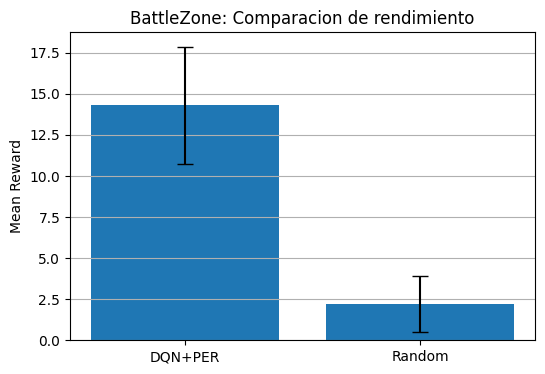

In [13]:
# Tabla comparativa y barplot
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

results_df = pd.DataFrame(
    [
        {
            "Policy": "DQN+PER",
            "Mean": eval_mean,
            "Std": eval_std,
            "Episodes": FINAL_EVAL_EPISODES,
        },
        {
            "Policy": "Random",
            "Mean": rand_mean,
            "Std": rand_std,
            "Episodes": FINAL_EVAL_EPISODES,
        },
    ]
)
display(results_df)

plt.figure(figsize=(6, 4))
plt.bar(results_df["Policy"], results_df["Mean"], yerr=results_df["Std"], capsize=6)
plt.title("BattleZone: Comparacion de rendimiento")
plt.ylabel("Mean Reward")
plt.grid(axis="y")
plt.show()

## Plots
Graficas de entrenamiento y evaluacion visibles en el notebook.

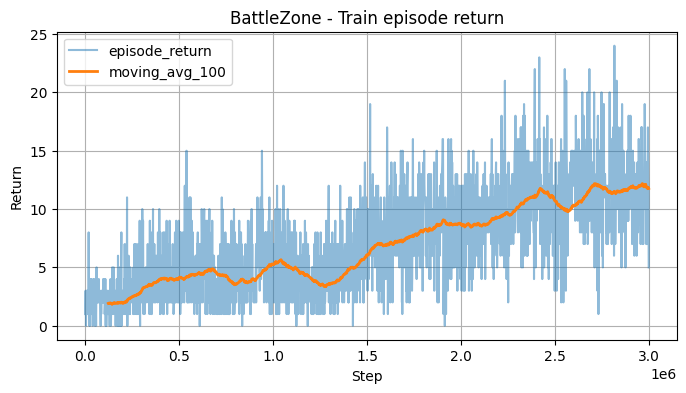

No hay evaluaciones periodicas registradas.


In [14]:
# Graficas de entrenamiento y evaluacion
import matplotlib.pyplot as plt
import numpy as np

if "train_episode_returns" in globals() and len(train_episode_returns) > 0:
    steps = np.array(train_episode_end_steps)
    returns = np.array(train_episode_returns)
    window = 100
    if len(returns) >= window:
        ma = np.convolve(returns, np.ones(window) / window, mode="valid")
        ma_steps = steps[window - 1 :]
    else:
        ma = None
        ma_steps = None

    plt.figure(figsize=(8, 4))
    plt.plot(steps, returns, label="episode_return", alpha=0.5)
    if ma is not None:
        plt.plot(ma_steps, ma, label=f"moving_avg_{window}", linewidth=2)
    plt.title("BattleZone - Train episode return")
    plt.xlabel("Step")
    plt.ylabel("Return")
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("No hay historial de entrenamiento en memoria para graficar.")

if "eval_history" in globals() and len(eval_history) > 0:
    eval_steps = [e["step"] for e in eval_history]
    eval_means = [e["mean"] for e in eval_history]
    eval_stds = [e["std"] for e in eval_history]
    plt.figure(figsize=(8, 4))
    plt.errorbar(eval_steps, eval_means, yerr=eval_stds, fmt="-o", capsize=4)
    plt.title("BattleZone - Eval mean return vs step")
    plt.xlabel("Step")
    plt.ylabel("Mean Return")
    plt.grid(True)
    plt.show()
else:
    print("No hay evaluaciones periodicas registradas.")

## Video
**Como grabar el video final (guion)**
1) Mostrar 10-15s de entrenamiento: logs o TensorBoard con `episode_return` y `loss`.
2) Mostrar 10-15s de ejecucion del agente en BattleZone.
3) Cerrar con la tabla de evaluacion (mean/std) de 10 episodios.

In [15]:
# Exportar un video corto de evaluacion
final_model_path = os.path.join(FINAL_DIR, "final_model.pth")
if os.path.exists(final_model_path):
    agent.online.load_state_dict(torch.load(final_model_path, map_location=DEVICE))
    agent.online.eval()
_ = run_eval(config["env_id"], n_episodes=1, seed_offset=9999, record_video=True)
print("Video guardado en:", VIDEO_DIR)

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/artifacts/battlezone/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Video guardado en: /content/artifacts/battlezone/videos


In [16]:
# Reproducir video inline
from IPython.display import Video, display
import glob

video_files = sorted(glob.glob(os.path.join(VIDEO_DIR, "*.mp4")))
if not video_files:
    print("No se encontraron videos en:", VIDEO_DIR)
else:
    print("Mostrando:", video_files[-1])
    display(Video(video_files[-1], embed=True))

Mostrando: /content/artifacts/battlezone/videos/battlezone_eval-episode-0.mp4


## TensorBoard (opcional)

Ejecuta en Colab:

```
%load_ext tensorboard
%tensorboard --logdir artifacts/battlezone/logs
```

## Reporte tecnico

**1) Justificacion (DQN+PER en BattleZone)**

BattleZone es un entorno Atari de alta dimensionalidad visual con perspectiva en primera persona, un espacio de 18 acciones discretas y recompensas dispersas otorgadas por la destruccion de vehiculos enemigos (tanques, misiles, supertanques y platillos). Se selecciono DQN + Prioritized Experience Replay (PER) por las siguientes razones:

- **DQN** es el baseline estandar para entornos Atari basados en pixeles, con arquitectura convolucional probada en los 57 juegos del Arcade Learning Environment (Mnih et al., 2015).
- **PER** mejora la eficiencia muestral al priorizar transiciones con alto TD-error. En BattleZone, donde los encuentros con enemigos son esporadicos y la mayoria de frames contienen movimiento sin recompensa, PER asegura que las experiencias informativas (destruccion de enemigos, perdida de vida) se repitan con mayor frecuencia en el entrenamiento.
- Con 18 acciones, la probabilidad de seleccionar aleatoriamente una accion util es ~5.5%, comparado con ~14% en Assault (7 acciones). PER compensa esta dificultad exploratoria al extraer mayor aprendizaje de cada experiencia relevante.

**2) Algoritmo (resumen)**

Se entrena una red Q convolucional (Nature DQN) sobre stacks de 4 frames en escala de grises de $84\times84$ pixeles. El target de la red Q se calcula como:

$$y = r + \gamma \max_a Q_{\text{target}}(s', a) \cdot (1 - \text{done})$$

La red objetivo se sincroniza con la red online cada `target_update_interval` pasos. PER usa un SumTree para muestreo proporcional con prioridades $p_i = |\delta_i| + \epsilon$ elevadas a $\alpha$. Los pesos de importancia $(N \cdot p_i)^{-\beta}$ corrigen el sesgo de muestreo, con $\beta$ que aumenta linealmente de 0.4 a 1.0 durante el entrenamiento.

**3) Hiperparametros**

| Parametro | Valor | Nota |
|---|---|---|
| env_id | ALE/BattleZone-v5 | 18 acciones, perspectiva 3D |
| frame_skip | 4 | Estandar Atari |
| clip_rewards | True | Normaliza recompensas a [-1, 1] |
| total_steps | 3,000,000 | +50% vs Assault por mayor espacio de acciones |
| learning_starts | 80,000 | Mas warmup para cubrir 18 acciones |
| update_every | 4 | Frecuencia de updates |
| batch_size | 32 | Estandar DQN |
| buffer_size | 100,000 | Optimizado para RAM Colab (~3.5GB) |
| gamma | 0.99 | Factor de descuento |
| lr | 6.25e-5 | Mas conservador que Assault (1e-4); valor del paper Rainbow para entornos complejos |
| target_update_interval | 10,000 | Sync target network |
| checkpoint_interval | 500,000 | Para reanudar en multiples sesiones Colab |
| eval_interval | 0 | Deshabilitado para ahorrar RAM |
| epsilon | 1.0 -> 0.01 en 1.5M pasos | Decay mas lento (50% del total) |
| PER alpha | 0.6 | Exponente de prioridad |
| PER beta | 0.4 -> 1.0 en 2M pasos | Correccion de sesgo gradual |
| seed | 123 | Reproducibilidad |

**Justificacion de cambios vs Assault:**
- **total_steps 3M** (vs 2M): 18 acciones requieren mas exploracion para descubrir combinaciones utiles.
- **learning_starts 80K** (vs 50K): buffer necesita mas datos aleatorios diversos con 18 acciones.
- **lr 6.25e-5** (vs 1e-4): LR mas bajo previene sobreescritura de Q-values para acciones poco visitadas. Valor recomendado en el paper Rainbow (Hessel et al., 2018).
- **eps_decay_steps 1.5M** (vs 1M): mantiene ratio 50% decay/total, permitiendo exploracion prolongada.
- **beta_steps 2M** (vs 1M): correccion de importancia mas gradual para estabilidad.

**Optimizaciones para Colab (identicas a Assault):**
- Buffer 100K (~3.5GB RAM vs 7.5GB con 200K)
- Eval periodica deshabilitada (solo eval final)
- Logging cada 1000 steps, episodios cada 10
- GC forzado cada 50 episodios
- Checkpoints cada 500K con validacion automatica

**4) Librerias y versiones**

Se imprimen en la celda de Setup:
- Python 3.12.x
- PyTorch 2.x + CUDA
- Gymnasium 1.2.x
- ale_py 0.11.x
- TensorBoard

**5) Hardware**

Entrenado en Google Colab con GPU (A100 o T4 segun disponibilidad). Se imprime `nvidia-smi` en la celda de Setup.

**6) Tiempo total de entrenamiento**

Se imprime al finalizar el loop de entrenamiento. Estimado: 12-18 horas para 3M pasos en A100 (episodios mas largos que Assault). El sistema de checkpoints permite dividir en 2-3 sesiones de Colab.

**7) Resultados cuantitativos (10 episodios)**

Se reportan la media y desviacion estandar para DQN+PER y politica aleatoria en la tabla comparativa de la celda de evaluacion formal. En BattleZone, la recompensa se mide en puntos acumulados (sin clip) durante la evaluacion.

Nota: dado que `clip_rewards=True` se usa tanto en entrenamiento como evaluacion, las recompensas reportadas estaran en escala clipeada (cada destruccion = +1.0 en vez de los puntos originales). Esto es consistente entre el agente entrenado y la baseline aleatoria.

**8) Graficas**

- **Train episode return**: retorno por episodio con media movil (ventana 100). Muestra la tendencia de aprendizaje.
- Sin evaluaciones periodicas (para ahorrar RAM). TensorBoard contiene metricas adicionales (loss, TD-error, mean Q, epsilon).

**9) Comportamiento aprendido y relacion con hiperparametros**

BattleZone presenta desafios unicos comparado con otros entornos Atari:
- **Perspectiva 3D**: los enemigos aparecen a distancias variables, requiriendo que la CNN aprenda invarianza de escala.
- **Radar**: informacion adicional en la pantalla que indica posicion de enemigos fuera del campo de vision.
- **18 acciones**: muchas combinaciones de movimiento + disparo. El agente debe aprender que acciones como FIRE y UPFIRE son utiles, mientras NOOP y movimientos laterales sin proposito no lo son.

Comportamientos esperados del agente entrenado:
- Avanzar hacia enemigos detectados (en vez de girar sin rumbo).
- Disparar cuando hay un objetivo en el centro de la pantalla.
- PER prioriza las experiencias de combate, permitiendo al agente aprender de encuentros enemigos esporadicos.
- El decay lento de epsilon (1.5M pasos) asegura exploracion suficiente del espacio de 18 acciones.
- El LR conservador (6.25e-5) previene que el agente "olvide" acciones utiles poco frecuentes.

No se espera comportamiento optimo (humano ~37,800 puntos, Nature DQN ~26,300 con 200M frames). Con 3M pasos y buffer de 100K, el agente debe demostrar comportamiento no aleatorio: movimiento dirigido y disparo intencional.

**10) Conclusiones y limitaciones**

DQN+PER es una eleccion solida para BattleZone dado su espacio de acciones grande y recompensas dispersas. PER mitiga la ineficiencia muestral al priorizar experiencias de combate sobre frames vacios.

**Limitaciones principales:**
- Buffer de 100K es restrictivo para un entorno 3D complejo (la literatura recomienda 500K-1M).
- 3M pasos es una fraccion del benchmark estandar (200M frames en los papers originales).
- Sin evaluaciones periodicas, la visibilidad del progreso durante entrenamiento es limitada.
- El reward clipping pierde informacion sobre el valor relativo de diferentes enemigos (tanque=1000, platillo=5000 -> ambos clippeados a 1.0).

**Trade-offs realizados:**
- Se sacrifico eficiencia muestral y diversidad de experiencia por estabilidad de ejecucion en Colab.
- El LR mas bajo compensa parcialmente el buffer reducido al permitir actualizaciones mas estables.
- El sistema de checkpoints habilita entrenamiento multi-sesion, critico para 3M pasos.

**Comparacion con resultados de Assault:**
- Assault (7 acciones): el agente aprendio a disparar efectivamente con 2M pasos.
- BattleZone (18 acciones): se requieren mas pasos y exploracion mas prolongada, pero la arquitectura y el algoritmo escalan directamente al nuevo entorno.